In [ ]:
#Basic project to understand domain adaptaion
#Domain Adversarial Neural Network
#MNIST to SVHN
#A100

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [11]:
# Need ato convert MNIST to 3 channels
transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_svhn = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

svhn_train = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
svhn_loader = DataLoader(svhn_train, batch_size=128, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat


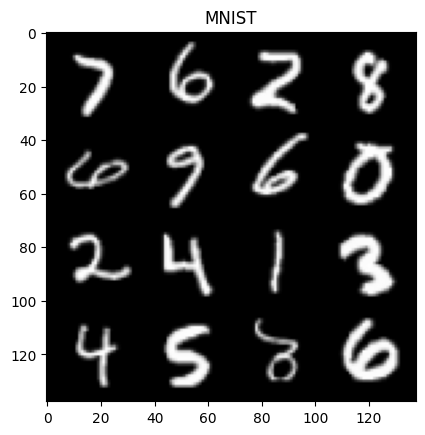

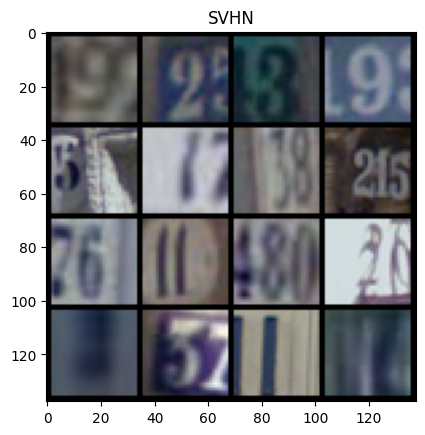

In [12]:
def visualize_samples(loader, title):
    images, labels = next(iter(loader))
    images = images[:16]
    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(title)
    plt.show()

visualize_samples(mnist_loader, "MNIST")
visualize_samples(svhn_loader, "SVHN")

## Model

### Basic CNN

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        outputs = self.classifier(features)
        return outputs

    def extract_features(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features

In [14]:
def train_baseline(model, dataloader, criterion, optimizer):
    model.train()
    for epoch in range(5):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

### DANN

In [18]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

In [19]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.label_predictor = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, 2)  # Domain: 0-source, 1-target
        )

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        reverse_features = GradientReversalFunction.apply(features, alpha)
        label_preds = self.label_predictor(features)
        domain_preds = self.domain_classifier(reverse_features)
        return label_preds, domain_preds

    def extract_features(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features

In [20]:
def train_dann(model, source_loader, target_loader, criterion, optimizer, num_epochs=5, alpha_max=1.0):
    model.train()
    len_source_loader = len(source_loader)
    len_target_loader = len(target_loader)

    for epoch in range(1, num_epochs + 1):
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        for batch_idx in range(len_source_loader):
            p = float(batch_idx + epoch * len_source_loader) / (num_epochs * len_source_loader)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            source_data, source_labels = next(source_iter)
            source_data, source_labels = source_data.to(device), source_labels.to(device)

            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            target_data = target_data.to(device)

            optimizer.zero_grad()
            source_label_preds, source_domain_preds = model(source_data, alpha)
            _, target_domain_preds = model(target_data, alpha)

            label_loss = criterion(source_label_preds, source_labels)
            domain_labels_source = torch.zeros(source_data.size(0)).long().to(device)
            domain_labels_target = torch.ones(target_data.size(0)).long().to(device)

            domain_loss_source = criterion(source_domain_preds, domain_labels_source)
            domain_loss_target = criterion(target_domain_preds, domain_labels_target)

            domain_loss = domain_loss_source + domain_loss_target
            total_loss = label_loss + domain_loss

            total_loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch}/{num_epochs}], Label Loss: {label_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}")

## Training & Evaluate

In [21]:
def evaluate(model_name, model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            if model_name == "DANN":
                outputs, _ = model(imgs)
            else:
                outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

### CNN train at MNIST

In [22]:
baseline_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
train_baseline(baseline_model, mnist_loader, criterion, optimizer)

Epoch 1, Loss: 0.0346
Epoch 2, Loss: 0.0592
Epoch 3, Loss: 0.0109
Epoch 4, Loss: 0.0081
Epoch 5, Loss: 0.0012


In [23]:
mnist_acc = evaluate("CNN", baseline_model, mnist_loader)
print(f"Baseline Accuracy on MNIST: {mnist_acc:.2f}")

Baseline Accuracy on MNIST: 1.00


In [24]:
svhn_acc = evaluate("CNN", baseline_model, svhn_loader)
print(f"Baseline Accuracy on SVHN: {svhn_acc:.2f}")

Baseline Accuracy on SVHN: 0.28


### CNN train at SVHN

In [30]:
CNN_SVHN_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_SVHN_model.parameters(), lr=0.001)
train_baseline(CNN_SVHN_model, svhn_loader, criterion, optimizer)

Epoch 1, Loss: 0.8553
Epoch 2, Loss: 0.3028
Epoch 3, Loss: 0.2643
Epoch 4, Loss: 0.3562
Epoch 5, Loss: 0.1747


In [31]:
mnist_acc = evaluate("CNN", CNN_SVHN_model, mnist_loader)
print(f"Baseline Accuracy on MNIST: {mnist_acc:.2f}")

Baseline Accuracy on MNIST: 0.56


In [32]:
svhn_acc = evaluate("CNN", CNN_SVHN_model, svhn_loader)
print(f"Baseline Accuracy on SVHN: {svhn_acc:.2f}")

Baseline Accuracy on SVHN: 0.94


### DANN

In [35]:
dann_model = DANN().to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dann(dann_model, mnist_loader, svhn_loader, criterion, optimizer_dann, num_epochs=3)

Epoch [1/3], Label Loss: 0.2479, Domain Loss: 0.0672
Epoch [2/3], Label Loss: 0.1027, Domain Loss: 0.0566
Epoch [3/3], Label Loss: 0.4266, Domain Loss: 1.8317


In [36]:
svhn_acc_dann = evaluate("DANN", dann_model, svhn_loader)
print(f"DANN Accuracy on SVHN: {svhn_acc_dann:.2f}")

DANN Accuracy on SVHN: 0.11


In [46]:
dann_model = DANN().to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dann(dann_model, mnist_loader, svhn_loader, criterion, optimizer_dann, num_epochs=5)

Epoch [1/5], Label Loss: 0.0925, Domain Loss: 0.0628
Epoch [2/5], Label Loss: 0.0513, Domain Loss: 0.0351
Epoch [3/5], Label Loss: 0.2275, Domain Loss: 0.0843
Epoch [4/5], Label Loss: 0.4102, Domain Loss: 0.8658
Epoch [5/5], Label Loss: 0.2652, Domain Loss: 0.0044


In [47]:
svhn_acc_dann = evaluate("DANN", dann_model, svhn_loader)
print(f"DANN Accuracy on SVHN: {svhn_acc_dann:.2f}")

DANN Accuracy on SVHN: 0.16


In [48]:
dann_model = DANN().to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_dann(dann_model, mnist_loader, svhn_loader, criterion, optimizer_dann, num_epochs=20)

Epoch [1/20], Label Loss: 0.2046, Domain Loss: 0.1267
Epoch [2/20], Label Loss: 0.5260, Domain Loss: 0.2332
Epoch [3/20], Label Loss: 0.5229, Domain Loss: 0.9009
Epoch [4/20], Label Loss: 0.3989, Domain Loss: 0.0949
Epoch [5/20], Label Loss: 0.5219, Domain Loss: 1.7417
Epoch [6/20], Label Loss: 0.4961, Domain Loss: 0.0691
Epoch [7/20], Label Loss: 0.3612, Domain Loss: 1.3087
Epoch [8/20], Label Loss: 0.5535, Domain Loss: 0.3712
Epoch [9/20], Label Loss: 2.0107, Domain Loss: 0.3117
Epoch [10/20], Label Loss: 1.6927, Domain Loss: 0.2943
Epoch [11/20], Label Loss: 1.5478, Domain Loss: 0.5295
Epoch [12/20], Label Loss: 1.5471, Domain Loss: 0.1834
Epoch [13/20], Label Loss: 1.4468, Domain Loss: 0.7894
Epoch [14/20], Label Loss: 1.5557, Domain Loss: 0.0971
Epoch [15/20], Label Loss: 1.4971, Domain Loss: 0.0964
Epoch [16/20], Label Loss: 1.4410, Domain Loss: 0.1861
Epoch [17/20], Label Loss: 1.1643, Domain Loss: 0.0233
Epoch [18/20], Label Loss: 1.1010, Domain Loss: 0.0121
Epoch [19/20], Labe

In [49]:
svhn_acc_dann = evaluate("DANN", dann_model, svhn_loader)
print(f"DANN Accuracy on SVHN: {svhn_acc_dann:.2f}")

# 학습 불안정함

DANN Accuracy on SVHN: 0.10


## Visualize

In [33]:
def tsne_visualize(model, loader, title, max_samples=2000):
    model.eval()
    features, labels = [], []
    sample_count = 0

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = model.extract_features(imgs)
            features.append(feats.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

            sample_count += len(lbls)
            if sample_count >= max_samples:
                break

    features = np.concatenate(features)[:max_samples]
    labels = labels[:max_samples]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='bright', s=30)
    plt.title(title)
    plt.show()

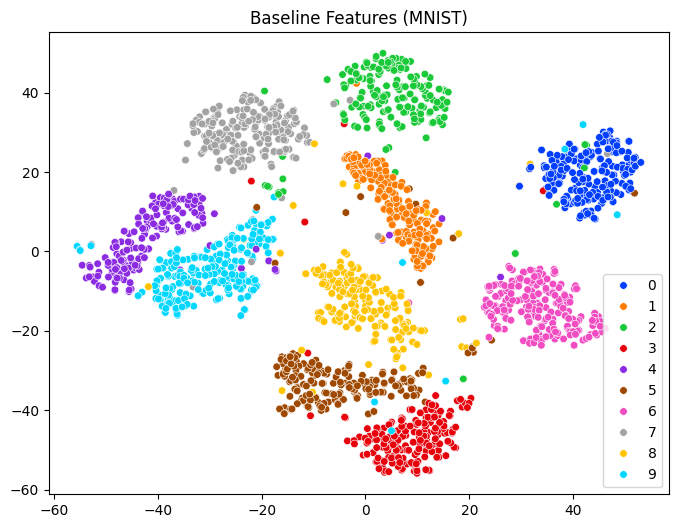

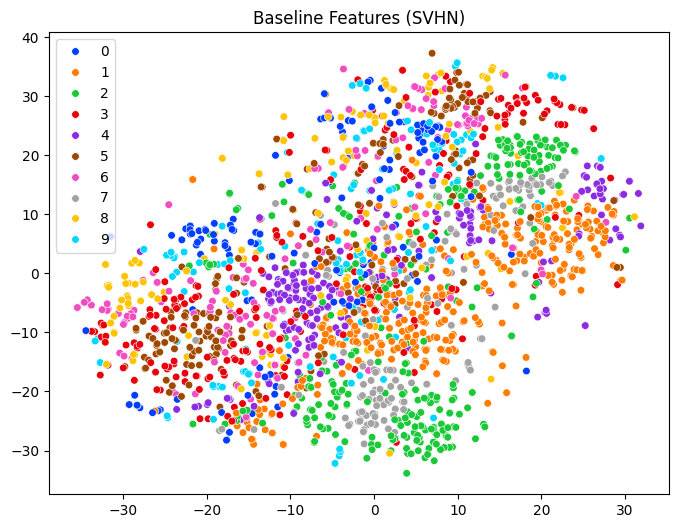

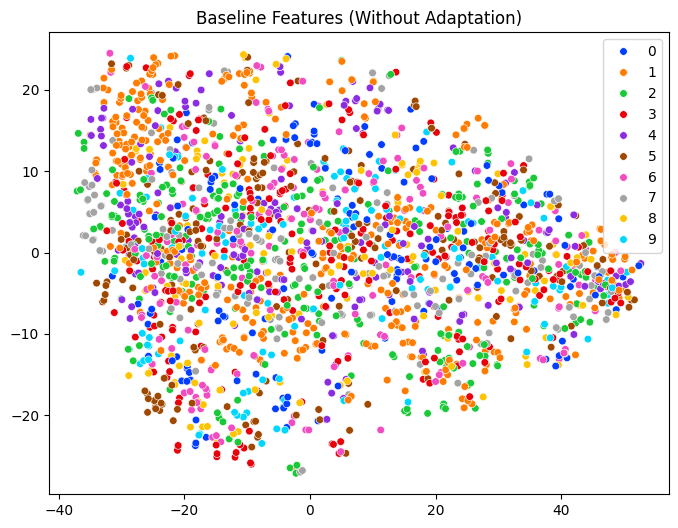

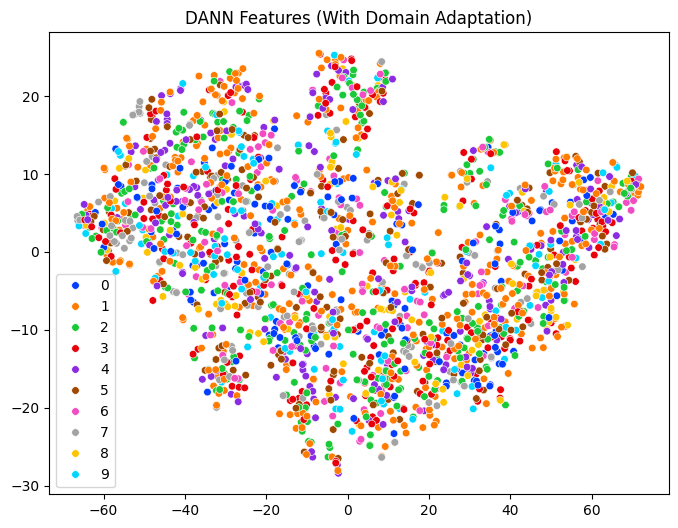

In [37]:
tsne_visualize(baseline_model, mnist_loader, "Baseline Features (MNIST)")
tsne_visualize(CNN_SVHN_model, svhn_loader, "Baseline Features (SVHN)")
tsne_visualize(baseline_model, svhn_loader, "Baseline Features (Without Adaptation)")
tsne_visualize(dann_model, svhn_loader, "DANN Features (With Domain Adaptation)")

In [44]:
def compare_predictions(models, dataloader, num_samples=16):
    images, labels = next(iter(dataloader))
    images, labels = images[:num_samples], labels[:num_samples]
    images, labels = images.to(device), labels.to(device)

    predictions = {}
    for model_name, model in models.items():
        model.eval()
        with torch.no_grad():
            if model_name == "DANN":
                outputs, _ = model(images)
            else:
                outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions[model_name] = preds.cpu().numpy()

    fig, axes = plt.subplots(4, num_samples // 4, figsize=(15, 8))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        img = images[idx].cpu().permute(1, 2, 0) * 0.5 + 0.5
        ax.imshow(img)
        title = f"True: {labels[idx].item()}\n"
        for model_name, preds in predictions.items():
            title += f"{model_name}: {preds[idx]}\n"
        ax.set_title(title, fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

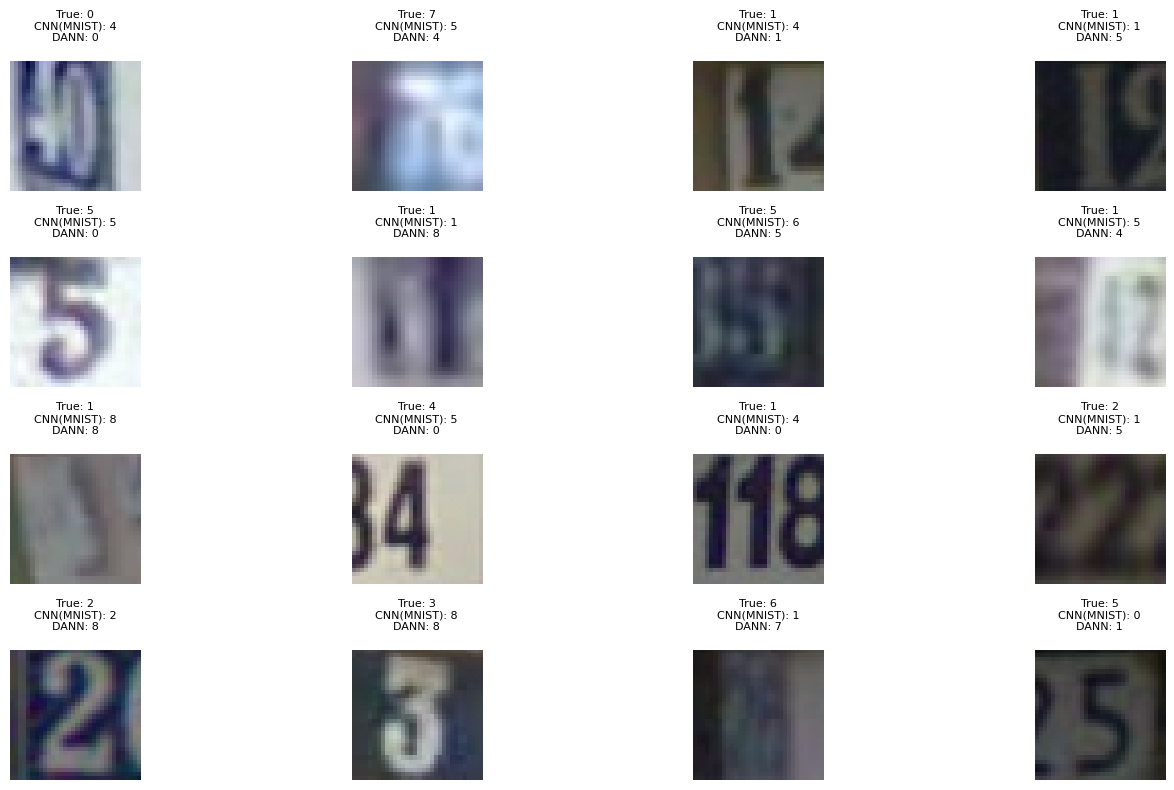

In [45]:
models = {
    "CNN(MNIST)": baseline_model,
    "DANN": dann_model
}

compare_predictions(models, svhn_loader, num_samples=16)

In [38]:
def visualize_predictions(model, model_name, loader, class_names, num_images=10):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, 6))
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if model_name == "DANN":
                outputs, _ = model(imgs)
            else:
                outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(imgs)):
                if images_shown >= num_images:
                    break
                images_shown += 1

                plt.subplot(2, num_images // 2, images_shown)
                img = imgs[i].cpu().numpy().transpose((1, 2, 0))
                img = (img * 0.5) + 0.5

                plt.imshow(img)
                plt.title(f"GT: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}")
                plt.axis('off')
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

class_names = [str(i) for i in range(10)]

CNN(MNIST) Predictions on MNIST:


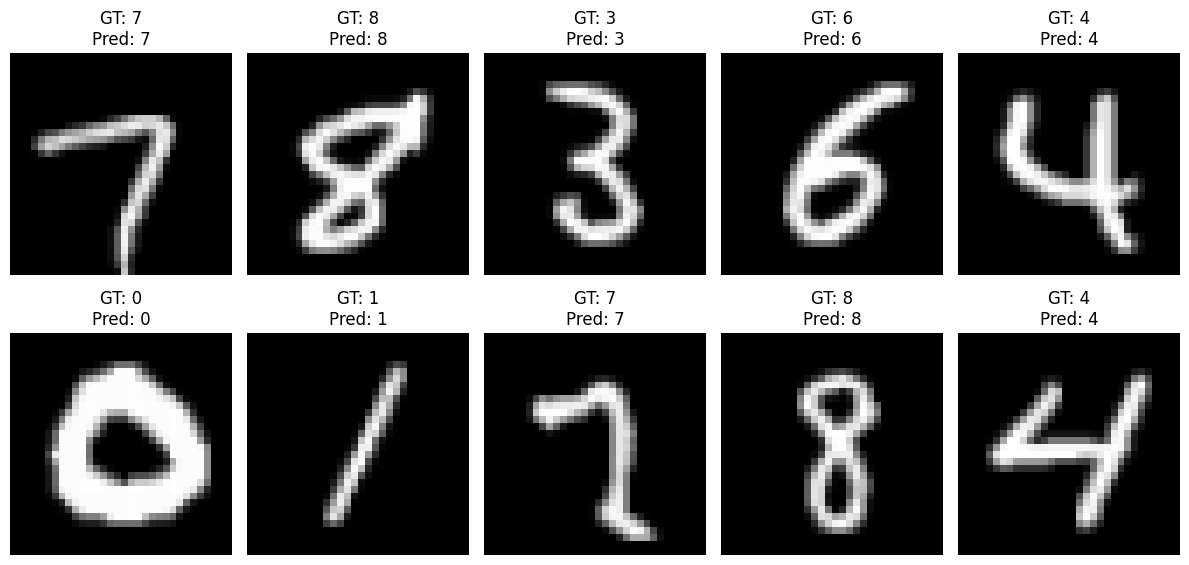

In [39]:
print("CNN(MNIST) Predictions on MNIST:")
visualize_predictions(baseline_model, "CNN", mnist_loader, class_names, num_images=10)

CNN(MNIST) Model Predictions on SVHN:


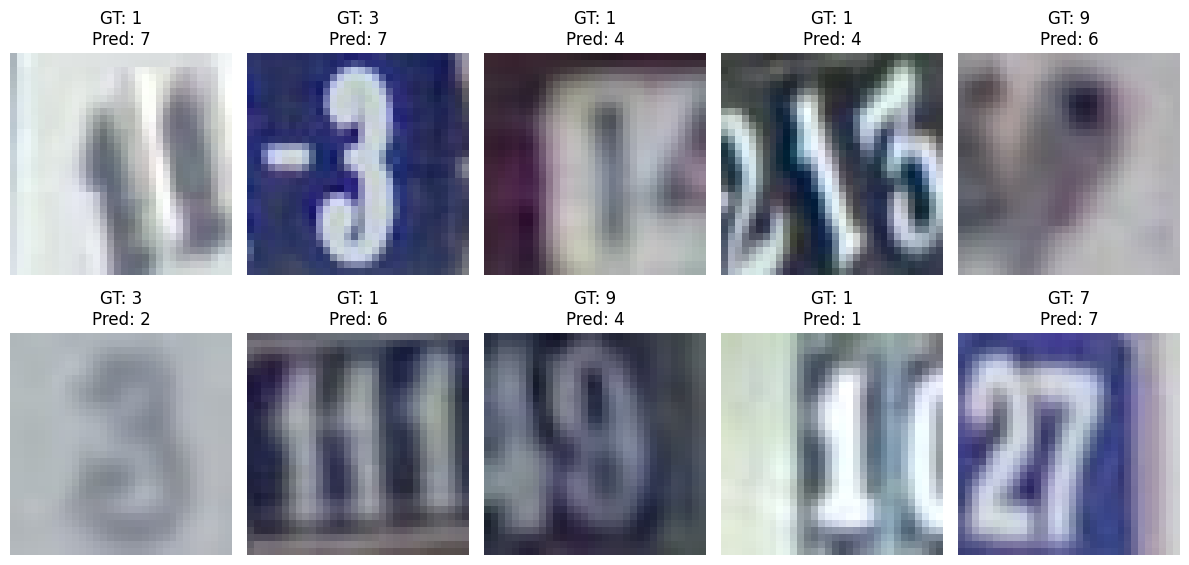

In [41]:
print("CNN(MNIST) Model Predictions on SVHN:")
visualize_predictions(baseline_model, "CNN", svhn_loader, class_names, num_images=10)

DANN Model Predictions on SVHN:


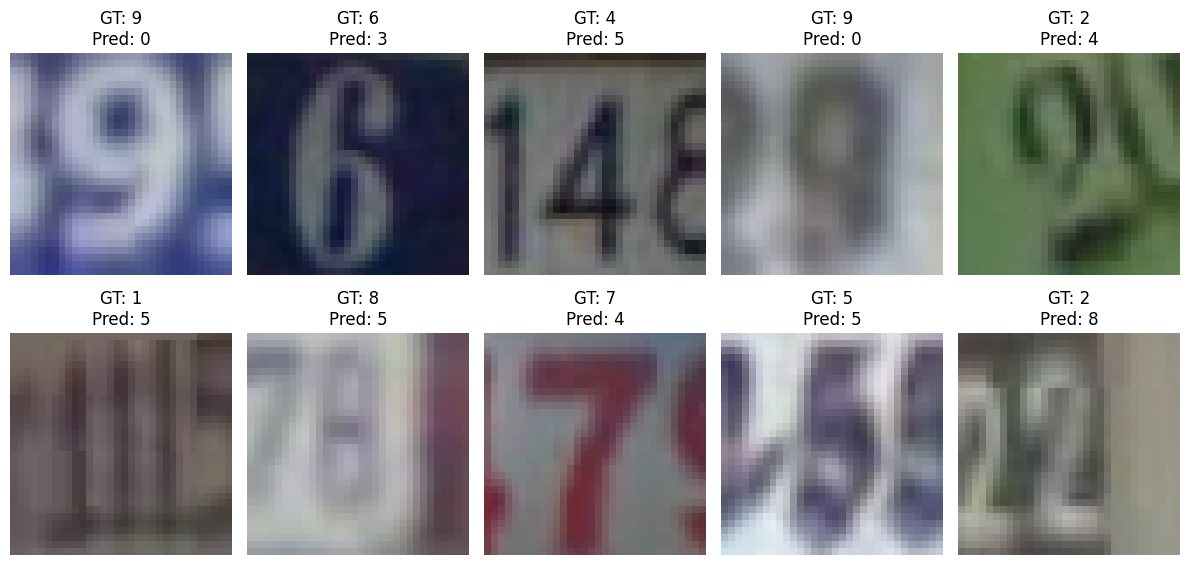

In [43]:
print("DANN Model Predictions on SVHN:")
visualize_predictions(dann_model,"DANN", svhn_loader, class_names, num_images=10)